In [905]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PrintNNinfo as out
import os, subprocess
from time import time
from tqdm import tqdm
import pickle as pkl
from scipy.ndimage import gaussian_filter1d, gaussian_filter
# from scipy.signal import butter, lfilter, hilbert, resample
from scipy.interpolate import interp1d
from scipy import signal

In [906]:
def CreateERnetwork(cell_types, ps):
    n = len(ps)
    syn_types = np.arange(n*n).reshape(n, n)
    cnt_map = np.ones([len(cell_types), len(cell_types)], dtype=int) * (-1)
    
    for i, cpre in enumerate(cell_types):
        for j, cpost in enumerate(cell_types):
            if i != j:
                if np.random.uniform() < ps[cpre][cpost]:
                    cnt_map[i][j] = syn_types[cpre][cpost]
    return cnt_map


def CreateFullnetwork(cell_types, ps):
    n = len(ps)
    syn_types = np.arange(n*n).reshape(n, n)
    cnt_map = np.ones([len(cell_types), len(cell_types)], dtype=int) * (-1)
    
    for i, cpre in enumerate(cell_types):
        for j, cpost in enumerate(cell_types):
            if i != j:
                cnt_map[i][j] = syn_types[cpre][cpost]
    return cnt_map    


def get_Poisson_t(f, N, tmax, dt, t0=0):
    prob = f*dt
    times = np.arange(t0, tmax, dt)
    ts = []
    for i in range(N):
        rand = np.random.uniform(low=0, high=1e3, size=len(times))
        ids = rand < prob
        ts.append(times[ids])
    return ts

def select_targets(n_stims, n_cells, n_overlap):
    targets = []
    for i in range(n_overlap):
        targets = np.concatenate((targets, [i for i in range(n_cells)]))
    targets = list(targets.astype(np.int))
        
    target_ids = []
    for i in range(n_stims):
        tid = [np.random.choice(targets)]
        targets.remove(tid)
        for j in range(n_overlap-1):
            n = np.random.choice(targets)
            while n in tid:
                n = np.random.choice(targets)
            tid.append(n)
            targets.remove(n)
        target_ids.append(tid)
    return target_ids

def set_ext_types(target_ids, n_ext_exc, cell_types, ext_syn_types):
    n_ext_inh = len(target_ids) - n_ext_exc
#     ext_syn_types = [[0, 1], [2, 3]] # ext_PN -> ? / ext_Inh -> ?
    ext_types = []
    for i, tid in enumerate(target_ids):
        ext_types.append([])
        if i < n_ext_exc:
            pre = 0
        else:
            pre = 1
        for n in tid:
            ext_types[-1].append(ext_syn_types[pre][cell_types[n]])
    return ext_types
    
    
def show_raster(tspks, n_exc):
    for i, t in enumerate(tspks):
        if i < n_exc:
            color = 'r'
        else:
            color = 'b'
        plt.vlines(t, i-0.5, i+0.5, color=color)
    
    
def read_all(prefix):
    t, v = out.readOut(prefix+'_v.csv')
    _, ii = out.readOut(prefix+'_i.csv')
    tspks = []
    for i in range(v.shape[1]):
        tspks.append(t[v[:, i] == 30])
    return t, v, ii, tspks


def getSTFFT(x, t, wbin=50000, mbin=1000, dt=0.01, maxf=200):
    ids = np.arange(wbin//2, len(x)-wbin//2, mbin)
#     ids = np.arange(0, len(x), mbin)
    f = np.fft.fftfreq(wbin, dt/(1e3))
    f = f[:wbin//2]
    idf = (f<200) & (f>1)
    psd = np.zeros([sum(idf), len(ids)])
    window = np.hanning(wbin-1)
    for n, i in enumerate(ids):
        y = x[i-wbin//2:(i+wbin//2-1)] * window
        fx = np.fft.fft(y)/wbin
        fx = abs(fx[:wbin//2])
        psd[:, n] = fx[idf]
    return t[ids], f[idf], psd
    
    
def getFFT(x, dt, fmax=None, idt=None):
    if idt is not None:
        x = x[idt]
    n = len(x)
    fx = np.fft.fft(x, n) / n
    f = np.fft.fftfreq(n, dt)
    fx = abs(fx[:int(n//2)])
    f = f[:int(n//2)]
    if fmax is not None:
        idf = f < fmax
        f = f[idf]
        fx = fx[idf]
    return f, fx


def show_grid(v, t, wbin=50000, mbin=100, s=5, norm=False, vmax=0.02):
    t, f, psd = getSTFFT(v, t, wbin=wbin)
    idf = f>10
    txy, fxy = np.meshgrid(t, f[idf])
    
    if norm:
        psd = psd - np.average(psd, axis=1).reshape(-1, 1)
    im = gaussian_filter(psd[idf, :], s)
    
    plt.pcolormesh(txy, fxy, im, cmap='jet', vmin=0, vmax=vmax)
    

def butter_bandpass(x, f_range, fs, order=5):
    nyq = 0.5 * fs
    f_range[0] /= nyq
    f_range[1] /= nyq
    
    b, a = signal.butter(order, f_range, btype='band')
    
    y = signal.lfilter(b, a, x)
    return y


def getPLV(v, t_stims, f_range, fs, order=5):
    y = butter_bandpass(v, f_range, fs, order)
    h = signal.hilbert(y)
    phi = np.angle(signal.hilbert(y))
    
    plv = 0
    n = 0
    for t_stim in t_stims:
        for t in t_stim:
            i = int(t/1e3*fs)
            plv += np.exp(1j*phi[i])
            n += 1
    
    plv = abs(plv) / n
    return plv


def merge_lists(a1, a2):
    arrs = []
    for a in a1:
        arrs.append(a)
    for a in a2:
        arrs.append(a)
    return arrs


def get_sync_index(vall, ind=None):
    # vall (:, n_cells)
    if ind is None:
        ind = np.ones(vall.shape[0], dtype=bool)
    
    v_avg = np.average(vall, axis=1)
    s_all = np.std(v_avg[ind])**2
    s_cell = np.std(vall[ind, :], axis=0)
    
    numer = np.average(s_all)
    denom = np.average(s_cell**2)
    
    return numer/denom

def get_sync_hist(vall, srate, wbin=10, mbin=5):
    
    ids = np.arange(wbin//2, vall.shape[0]-wbin//2, mbin)
    hists = np.zeros(len(ids))
    t = np.arange(wbin//2, vall.shape[0]-wbin//2, mbin)/srate*1e3
    
    for n, ind in enumerate(ids):
        hists[n] = np.sum(vall[(ind-wbin//2):(ind+wbin//2-1), :] == 30)
    
    return hists, t


def auto_corr(x, tmax, srate, ind=None):
    if ind is not None:
        x = x[ind]
    kmax = int(tmax * srate)
    corr = []
    ks = np.arange(0, kmax+0.1, 1) / srate
    xm = np.average(x)
    for k in range(kmax+1):
        if k == 0:
            x1 = x
            x2 = x
        else: # k > 0
            x1 = x[:-k]
            x2 = x[k:]
        s1 = np.std(x1)
        s2 = np.std(x2)
        if ((s1==0) or (s2==0)):
            corr.append(0)
        else:
            corr.append(np.sum((x1-xm)*(x2-xm))/len(x)/(np.std(x1)*np.std(x2)))
    return ks, corr


In [985]:
np.random.seed(36633)

In [986]:
# set parameters
tmax = 1000
dt = 0.01

n_exc = 100
n_inh = 25

n_stims_pfc_pn = 100
n_stims_pfc_pv = 25
p_stims_pfc = [0.1, 0.1, 0.1, 0.1]

n_stims_pos = 125
p_stims_pos = [0.2, 0.2]

# Poisson input
f_pos = 85

# oscillatory input
t0 = 1500
t1 = 2000

# set PN cell type & cells parameter
params_pn = {'tau':20, 'r':500, 'e':-70, 'vahp':-80, 'vth':-40, 't_refrac':5, 'v0':-65, 'vmax':30}
params_pv = {'tau':2, 'r':500, 'e':-70, 'vahp':-80, 'vth':-40, 't_refrac':0.2, 'v0':-65, 'vmax':30}

# set synapse type & parameter
# syn_pn2pn = {'gmax':1e-3, 'tau_r':0.2, 'tau_d':4.6, 'e':0, 'd':1}
# syn_pn2pv = {'gmax':1e-4, 'tau_r':0.1, 'tau_d':1.3, 'e':0, 'd':1}
# syn_pv2pn = {'gmax':1e-2, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':1}
# syn_pv2pv = {'gmax':1e-3, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':1}

syn_pn2pn = {'gmax':1e-3, 'tau_r':0.2, 'tau_d':4.6, 'e':0, 'd':1}
syn_pn2pv = {'gmax':1e-4, 'tau_r':0.1, 'tau_d':1.3, 'e':0, 'd':1}
syn_pv2pn = {'gmax':1e-2, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':1}
syn_pv2pv = {'gmax':1e-3, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':1}

syn_type_params = [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv]

# set network parameters
ps = [[0.2, 0.2], [0.3, 0.3]] # PN->PN/Inh, Inh->PN/Inh

# PFC input 3, 1
pfc_pn2pn = {'gmax':2e-4, 'tau_r':0.2, 'tau_d':4.6, 'e':0, 'd':0}
pfc_pn2pv = {'gmax':2e-4, 'tau_r':0.1, 'tau_d':1.3, 'e':0, 'd':0}
pfc_pv2pn = {'gmax':5e-5, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':0}
pfc_pv2pv = {'gmax':5e-5, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':0}

# background input
ext_pn2pn = {'gmax':3.1e-4, 'tau_r':0.2, 'tau_d':4.6, 'e':0, 'd':0}
ext_pn2pv = {'gmax':3.1e-4, 'tau_r':0.1, 'tau_d':1.3, 'e':0, 'd':0}

ext_syn_type_params = [pfc_pn2pn, pfc_pn2pv, pfc_pv2pn, pfc_pv2pv, ext_pn2pn, ext_pn2pv]

# ---------------------------------------- #
# -------- Calculate network info -------- #
# ---------------------------------------- #

# create network
n_cells = n_exc + n_inh
cell_types = []
for i in range(n_cells):
    if i < n_exc:
        cell_types.append(0)
    else:
        cell_types.append(1)
cnt_map = CreateERnetwork(cell_types, ps)

n_stims_pfc = n_stims_pfc_pn+n_stims_pfc_pv
# create t_stims & id at 28 Hz
t_stims_pfc = get_Poisson_t(f_pos, n_stims_pfc, tmax, dt, t0=0)
for i in range(n_stims_pfc):
    t = t0
    tmp = []
    while t < t1:
        val = t + np.random.normal(loc=0, scale=1)
        if val < t1:
            tmp.append(val)
        t += 1e3/28
    t_stims_pfc[i] = np.concatenate((t_stims_pfc[i], tmp))
    t_stims_pfc[i] = np.sort(t_stims_pfc[i])
t_stims_pos = get_Poisson_t(f_pos, n_stims_pos, tmax, dt, t0=0)

t_stims = merge_lists(t_stims_pfc, t_stims_pos)

# get ids
ids_targets = []
for i in range(n_stims_pfc+n_stims_pos):
    if i < n_stims_pfc_pn:
        prob = p_stims_pfc[:2]
    elif i < n_stims_pfc:
        prob = p_stims_pfc[2:]
    else:
        prob = p_stims_pos
    ids_targets.append([])
    for j in range(n_cells):
        c = cell_types[j]
        p = np.random.uniform(low=0, high=1)
        if p < prob[c]:
            ids_targets[i].append(j)

# external types
ext_types = []
for i in range(n_stims_pfc + n_stims_pos):
    if i < n_stims_pfc_pn:
        n0 = 0
    elif i < n_stims_pfc:
        n0 = 1
    else:
        n0 = 2
    ext_types.append([])
    for ind in ids_targets[i]:
        c = cell_types[ind]
        ext_types[i].append(n0*2+c)


In [987]:
prefix = 'ntk_28'

out.print_nn_params('./parameter/', prefix, cell_types, cnt_map, [params_pn, params_pv], syn_type_params,
                    ids_targets, ext_types, t_stims, ext_syn_type_params, overwrite=True, d_noise=0.3, g_noise_syn=1e-5, g_noise_ext=0)

./parameter/ntk_28_cell.csv exists
./parameter/ntk_28_syn.csv exists
./parameter/ntk_28_t_spike.csv exists


In [988]:
tic = time()

subprocess.call(['./runNetwork',
                '--fdir', './parameter/', '--prefix', prefix, '--fsave', f'./vcells_{prefix}', '--tmax', '%d'%(tmax),
                 '--dt', '0.01', '--s', '0.2', '--seed', '1000'])
times, vall, iall, tspks = read_all(f'./vcells_{prefix}')

print(time()-tic, 's')

67.08911108970642 s


In [ ]:
plt.figure(dpi=200, figsize=(4, 3))

plt.subplot(311)
for i in range(125):
    if i < n_exc:
        c = 'r'
    else:
        c = 'b'
    plt.vlines(tspks[i], i-0.5, i+0.5, color=c, lw=1)
bars = np.arange(t0, t1, 1e3/28)
# plt.vlines(bars, 0, n_cells, 'k', lw=0.5)
# plt.xticks([]) 
plt.xticks([0, 500, 1000])
plt.yticks([])
plt.xlim([0, tmax])


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.subplot(312)
v_avg = np.average(vall, axis=1)
lfp = gaussian_filter1d(v_avg, 2)
plt.plot(times, lfp, lw=0.5, c='k')
plt.yticks([])
# plt.xticks(np.arange(0, 2100, 250))
# plt.xticks([0, t0, t1])
plt.xticks([0, 500, 1000])
plt.xlim([0, tmax])
# plt.ylabel('voltage (mV)')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.subplot(313)

plt.subplot(313)
srate = 2000
lfp_new = resample(lfp, srate//2+1)
t_new = np.arange(0, tmax+1e3/2/srate, 1e3/srate)


# v_avg1 = np.average(vall1, axis=1)
v_avg = np.average(vall, axis=1)
f, fx = getFFT(v_avg, dt/1e3)

plt.xlim([0, 100])
plt.ylim([-1, 1])

interp = interp1d(f[f>10], fx[f>10]**2, kind='cubic')
fnew = np.linspace(20, 80, 1000)
y = interp(fnew)

plt.plot(fnew, y, 'k', lw=1)
plt.xlim([20, 80])
plt.ylim([-0.05, 0.2])

# plt.xlabel('frequency (Hz)', fontsize=12)
# plt.ylabel(r'Power (mV$^{2}$)', fontsize=12)

plt.xticks([20, 40, 60, 80])
# plt.xticks([])
plt.yticks([])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


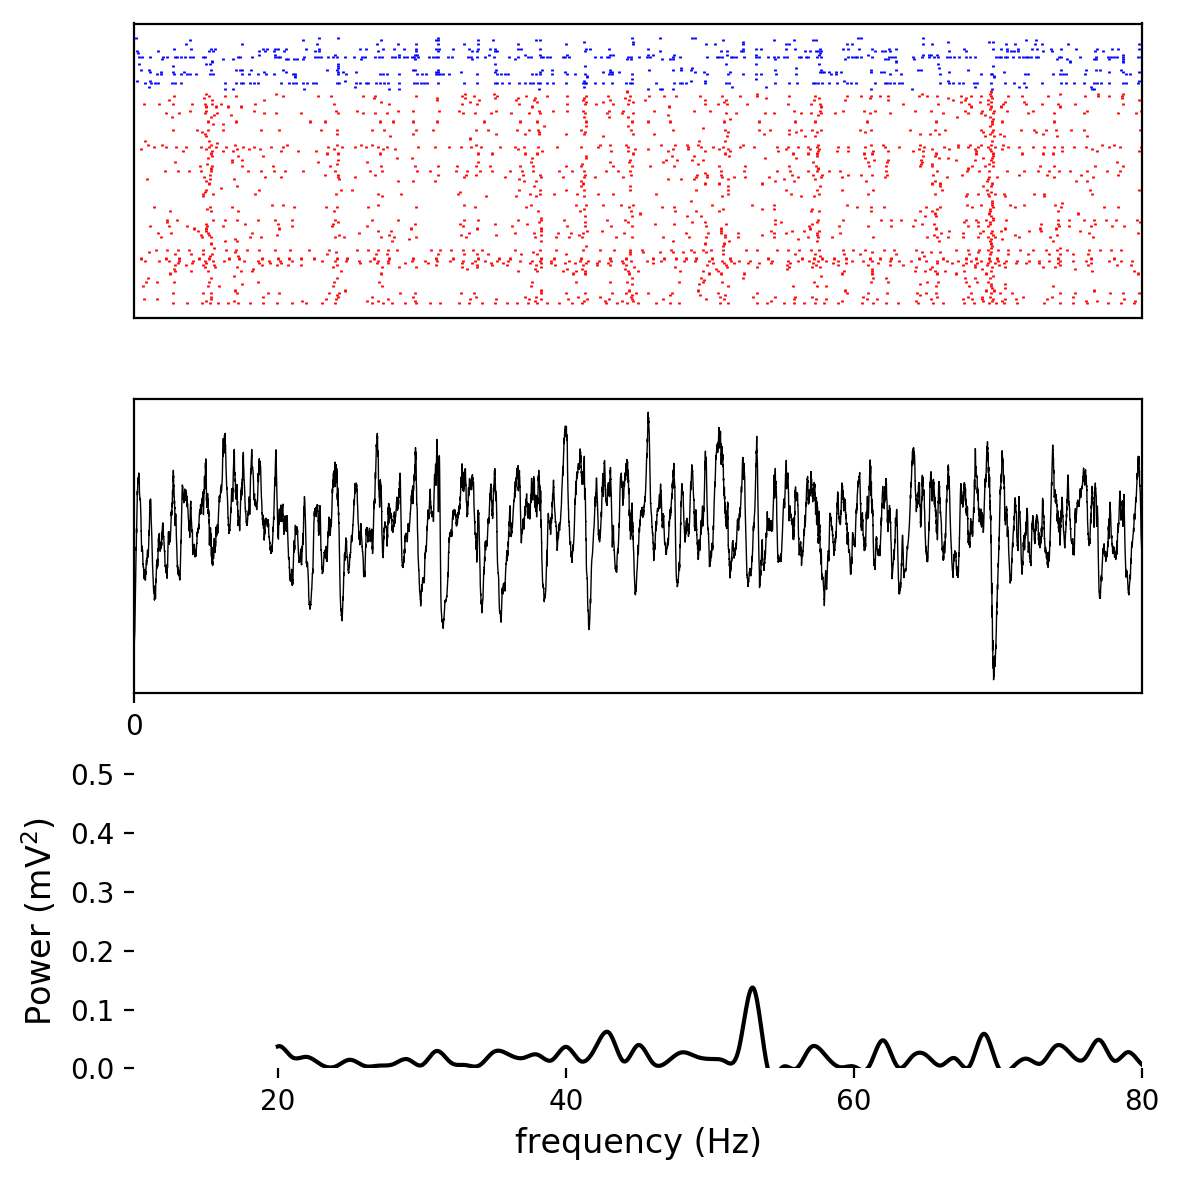

In [998]:
plt.figure(dpi=200, figsize=(6, 6))

figname = 'test_ext_%.5f_%.5f_pfc_%.5f_%.5f'%(ext_pn2pn['gmax'], ext_pn2pv['gmax'], ext_pn2pn_28['gmax'], ext_pn2pv_28['gmax'])

plt.subplot(311)
for i in range(n_cells):
    if i < n_exc:
        c = 'r'
    else:
        c = 'b'
    plt.vlines(tspks[i], i-0.5, i+0.5, color=c, lw=1)
    
bars = np.arange(t0, t1, 1e3/28)
# plt.vlines(bars, 0, n_cells, 'k', lw=0.5)
    
plt.xticks([]) 
plt.yticks([])
plt.xlim([0, tmax])


plt.subplot(312)

v_avg = np.average(vall, axis=1)
lfp = gaussian_filter1d(v_avg, 2)
plt.plot(times, lfp, lw=0.5, c='k')
plt.yticks([])
# plt.xticks(np.arange(0, 2100, 250))
plt.xticks([0, t0, t1])
plt.xlim([0, tmax])
# plt.ylabel('voltage (mV)')


plt.subplot(313)
srate = 2000
lfp_new = resample(lfp, srate//2+1)
t_new = np.arange(0, tmax+1e3/2/srate, 1e3/srate)
# ks_re, corr_re = auto_corr(lfp_new, tmax=0.1, srate=srate, ind=(t_new>300)&(t_new<500))
# plt.plot(ks_re*1e3, corr_re, 'k', lw=2)
# plt.vlines([1e3/28, 1e3/50, 1e3/60], -1, 1, 'r', linestyle='--')

# v_avg1 = np.average(vall1, axis=1)
v_avg = np.average(vall, axis=1)
f, fx = getFFT(v_avg, dt/1e3)

plt.xlim([0, 100])
plt.ylim([-1, 1])

interp = interp1d(f[f>10], fx[f>10]**2, kind='cubic')
fnew = np.linspace(20, 80, 1000)
y = interp(fnew)

plt.plot(fnew, y, 'k')
plt.xlim([10, 80])
plt.ylim([0, 0.5])

plt.xlabel('frequency (Hz)', fontsize=12)
plt.ylabel(r'Power (mV$^{2}$)', fontsize=12)

plt.xticks([20, 40, 60, 80])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


plt.tight_layout()
plt.savefig(os.path.join('./test_figs/', figname+'.png'))
plt.show()

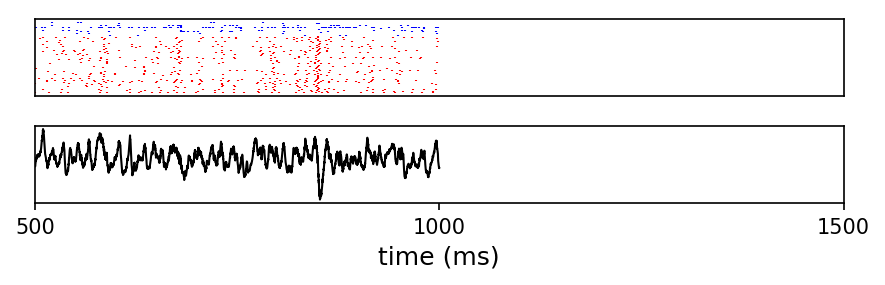

In [990]:
plt.figure(dpi=150, figsize=(6, 2))

plt.subplot(211)
for i in range(n_cells):
    if i < n_exc:
        c = 'r'
    else:
        c = 'b'
    plt.vlines(tspks[i], i-0.5, i+0.5, color=c, lw=1)
plt.xticks([])
plt.yticks([])
plt.xlim([500, 1500])

plt.subplot(212)

plt.plot(times, lfp, 'k', lw=1)
plt.xticks([0, 500, 1000, 1500, 2000])
plt.yticks([])
plt.xlim([500, 1500])
plt.xlabel('time (ms)', fontsize=12)

plt.tight_layout()
plt.show()

In [991]:
# v_avg1 = np.average(vall1, axis=1)
v_avg = np.average(vall, axis=1)
f, fx = getFFT(v_avg, dt/1e3)

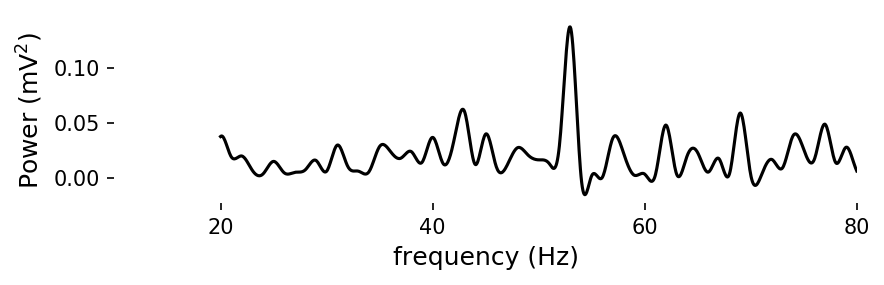

In [992]:
plt.figure(dpi=150, figsize=(6, 2))

interp = interp1d(f[f>10], fx[f>10]**2, kind='cubic')
fnew = np.linspace(20, 80, 1000)
y = interp(fnew)

plt.plot(fnew, y, 'k')

plt.xlim([10, 80])
# plt.ylim([0, 1])
plt.xlabel('frequency (Hz)', fontsize=12)
plt.ylabel(r'Power (mV$^{2}$)', fontsize=12)

plt.xticks([20, 40, 60, 80])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

(0, 1)

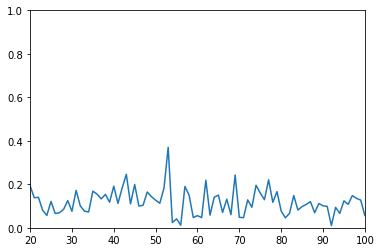

In [993]:
plt.plot(f, fx)
plt.xlim([20, 100])
plt.ylim([0, 1])

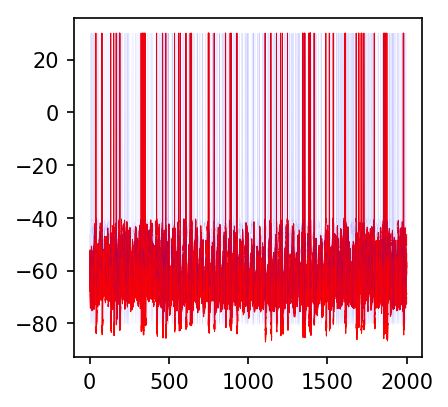

In [867]:
plt.figure(dpi=150, figsize=(3, 3))
for i in [0,1,2,3,4,5,6,80,81,82,101,105]:
    if i < n_exc:
        plt.plot(times, vall1[:, i], 'r', lw=0.5)
    else:
        plt.plot(times, vall1[:, i], 'b', lw=0.01)

plt.show()

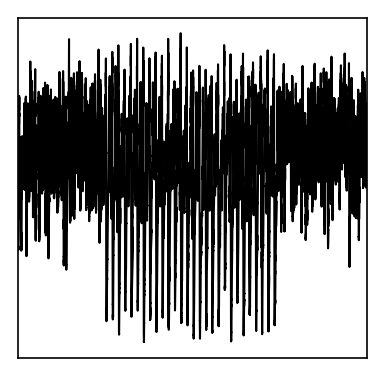

In [881]:
plt.figure(dpi=150, figsize=(3, 3))
# plt.plot(times, vall1[:, 100], 'k', lw=1)
plt.plot(times, np.average(vall1, axis=1), 'k', lw=1)
plt.xlim([0, 2000])
# plt.xlabel('time (ms)', fontsize=12)
plt.xticks([])
plt.yticks([])
plt.show()

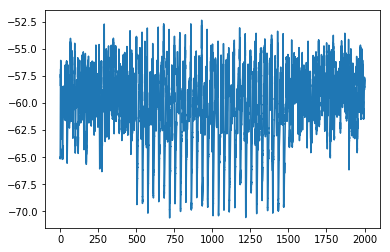

In [500]:
raster_map = np.zeros([n_cells, vall.shape[0]])
# gaussian kernel
x = np.arange(-(2*tmax+dt/2), 2*tmax+dt/2, dt)
sigma = 2
gauss = np.exp(-x**2/(2*sigma**2))
kernel = gauss / (sum(gauss)*dt)
ic = len(x) // 2

for n, ts in enumerate(tspks):
    for t in ts:
        i = int(t/dt)
        raster_map[n] += kernel[ic-i:ic-i+vall.shape[0]]

srate = 2000
n_sample = int(tmax/1e3*srate)
resampled_map = np.zeros([n_cells, n_sample])
for n in range(n_cells):
    resampled_map[n, :] = signal.resample(raster_map[n], n_sample)
        

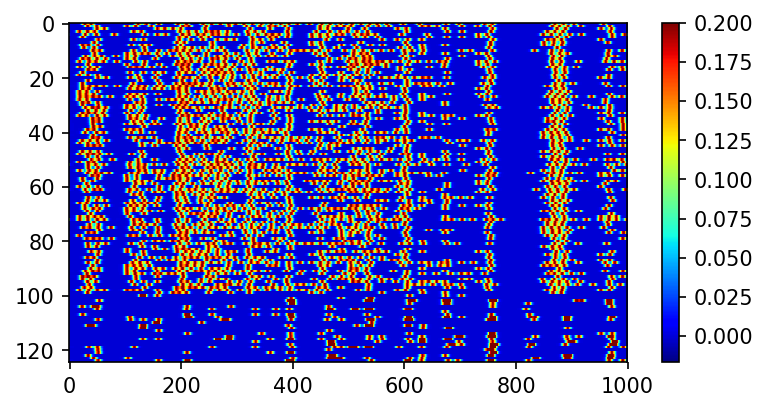

In [459]:
plt.figure(dpi=150, figsize=(6, 3))
plt.imshow(resampled_map, aspect='auto', cmap='jet', vmax=0.2)
# plt.pcolormesh(raster_map)
plt.colorbar()
plt.show()

In [461]:
ks, corr = auto_corr(resampled_map[0], kmax=200)

(-0.5, 0.5)

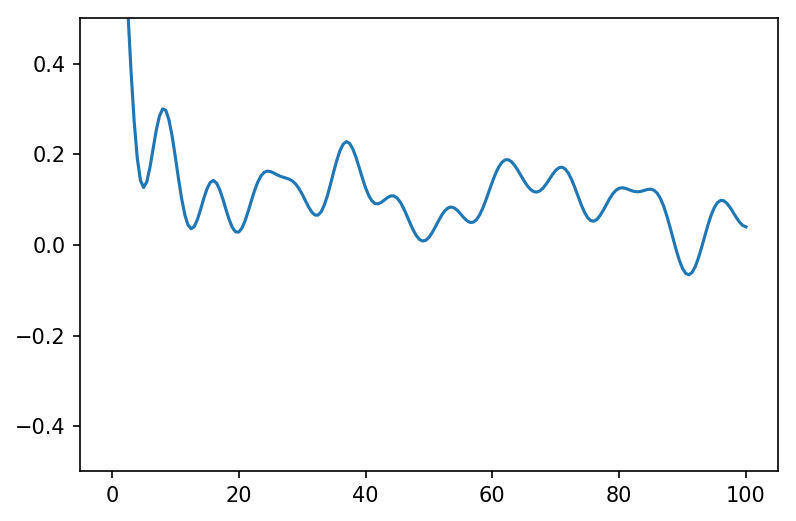

In [462]:
plt.figure(dpi=150, figsize=(6, 4))
plt.plot(ks/srate*1e3, corr)
# plt.xlim([0, 0.50])
plt.ylim([-0.5, 0.5])

In [478]:
id_peaks, _ = signal.find_peaks(corr, height=0.2, threshold=0, width=50)
if len(id_peaks) > 0:
    id_peaks = id_peaks[0]
    plt.vlines(id_peaks*dt, -1000, 1000, 'r', linestyles='--')
    print('%.2f Hz'%(1e3/(id_peaks*dt)))

In [479]:
id_peaks

array([], dtype=int64)

In [489]:
f, fx = getFFT(v_avg, (times>t0)&(times<t1), 0.01)

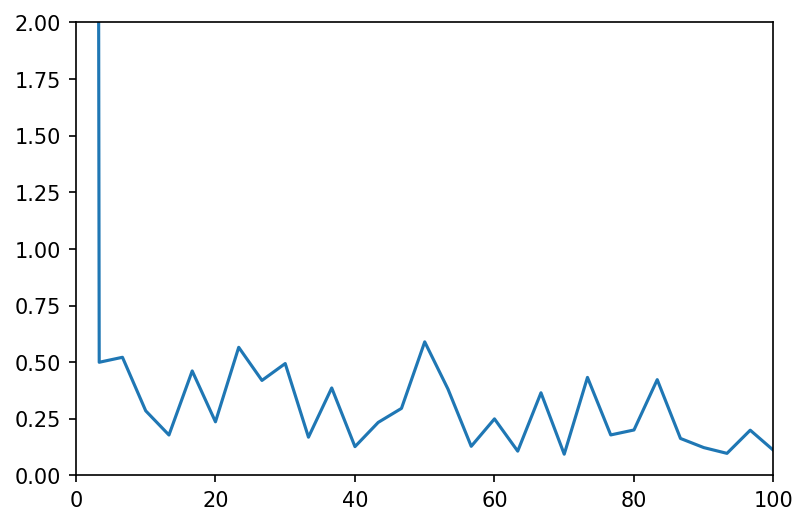

In [490]:
plt.figure(dpi=150)
plt.plot(f, fx)
plt.xlim([0,100])
plt.ylim([0, 2])
plt.show()

In [882]:
lfp = np.average(vall, axis=1)\

# bandpass filter
srate = 2000

n = int(tmax/1000*srate)+1

lfp = resample(lfp, n)
tnew = np.linspace(0, tmax, n)

yf = butter_bandpass(lfp, [25, 35], srate, order=1)
yp = np.angle(hilbert(yf))

# phase sync
sync_phs = []
# for ts in t_stims_28:
for ts in tspks:
    for t in ts:
        i = int(t/1e3*srate)-1
        sync_phs.append(yp[i])

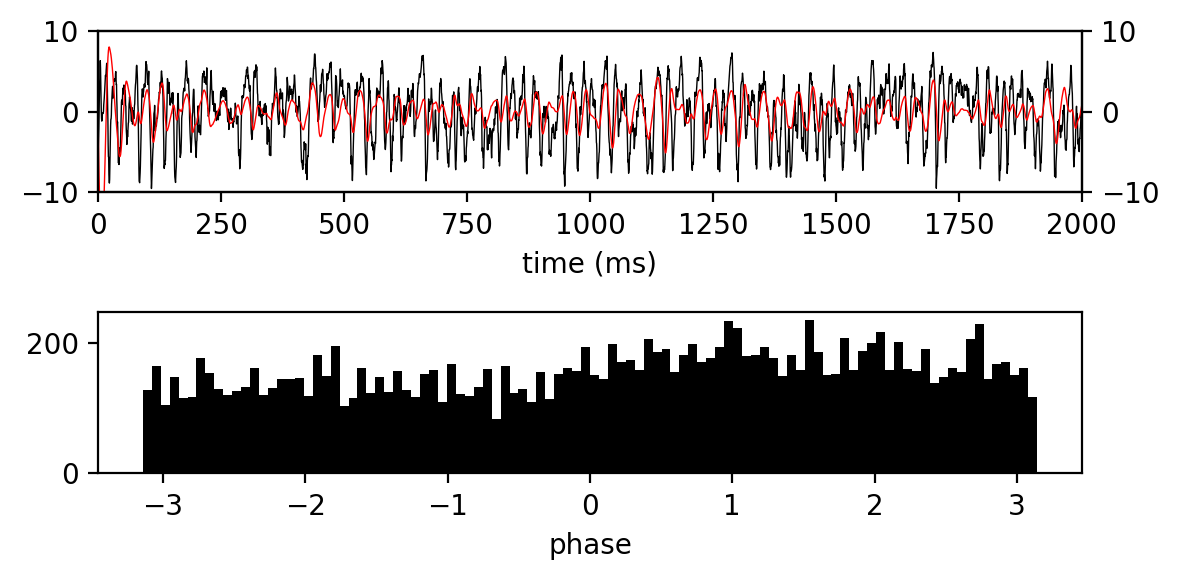

In [883]:
plt.figure(dpi=200, figsize=(6, 3))

plt.subplot(211)

plt.plot(tnew, lfp-np.average(lfp), 'k', lw=0.5)
plt.ylim([-10, 10])
plt.yticks([-10, 0, 10])
plt.xlabel('time (ms)')

plt.twinx()
plt.plot(tnew, yf-np.average(yf), 'r', lw=0.5)
plt.ylim([-10, 10])
plt.yticks([-10, 0, 10])
plt.xlim([0, tnew[-1]])

plt.subplot(212)
plt.hist(sync_phs, 100, facecolor='k')
plt.xlabel('phase')

plt.tight_layout()
plt.show()

In [482]:
hist, bin_edges = np.histogram(sync_phs, 100, range=[-np.pi, np.pi])
# normalize
hist = hist / (sum(hist)*(100/(2*np.pi)))

In [483]:
hist[hist == 0] = 1
hh = np.sum(-hist * np.log2(hist))
print(hh)

0.6598800580009168


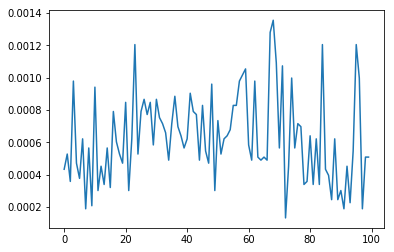

In [484]:
plt.plot(hist)

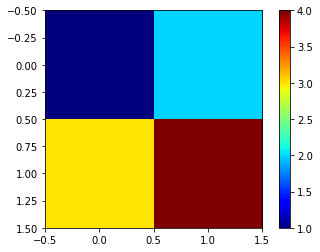

In [808]:
plt.imshow([[1, 2], [3, 4]], cmap='jet')
plt.colorbar()